In [1]:
from fastai.vision import *
from models import Darknet
from train import hyp
from utils import torch_utils
from utils.utils import compute_loss, build_targets


In [2]:
# https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-8-object-detection.md
voc2007 = untar_data(URLs.PASCAL_2007)
voc2012 = untar_data(URLs.PASCAL_2012)

In [3]:
# https://pjreddie.com/darknet/yolo/#train-voc
files = [
    voc2007 / 'train.json', 
    voc2007 / 'valid.json',
    voc2007 / 'test.json',
    voc2012 / 'train.json', 
    voc2012 / 'valid.json'
    ]
jsons = [(it, json.load(it.open())) for it in files]
images = [{**img, 'file': fn} for (fn, json) in jsons for img in json["images"]]
images = { i["id"] : i for i in images }
annotations = [item for (fn, json) in jsons for item in json["annotations"]]
f"{len(images)}; {len(annotations)}"

'21503; 62199'

In [4]:
for anno in annotations:
    image = images[anno['image_id']]
    image.setdefault('annotations', []).append(anno)


In [5]:
person_cat = [it for it in jsons[0][1]["categories"] if it["name"] == "person"][0]["id"]
person_cat

15

In [6]:
def has_person(img): 
    return [] != [a for a in img['annotations'] if a['category_id'] == person_cat]
positive_samp = [img for img in images.values() if has_person(img)]
negative_samp = [img for img in images.values() if not has_person(img)]
f"{len(positive_samp)}; {len(negative_samp)}"

'8566; 12937'

In [7]:
negative_samp = negative_samp[:len(positive_samp)]
len(negative_samp)

8566

In [8]:
samples = positive_samp + negative_samp

In [9]:
def get_folder(f):
    if 'train' in str(f) or 'valid' in str(f): return 'train'
    return 'test'
def make_path(p):
    return p['file'].parent / get_folder(p['file']) / p['file_name']
posix_paths = [make_path(p) for p in samples]
# lst = ImageList(posix_paths)
lst = ObjectItemList(posix_paths)

In [10]:
def split_func(sample):
    return '2007' in str(sample['file'].parent) and 'test' in str(sample['file'])
valid = set()
for sample in samples:
    if split_func(sample):
        valid.add(make_path(sample))
len(valid)

4952

In [11]:
# TODO: convert bbox https://github.com/cedrickchee/knowledge/blob/master/courses/fast.ai/deep-learning-part-2/2018-edition/lesson-8-object-detection.md#convert-vocs-bounding-box
def filename_to_key(filename):
    trunk = os.path.splitext(filename)[0]
    txt = trunk.replace("_", "")
    id = int(txt)
    return id
def get_y_func(path):
    key = filename_to_key(path.name)
    image = images[key]
    boxes = []
    classes = []
    for anno in image['annotations']:
        if anno['category_id'] != person_cat:
            continue
        boxes.append(anno['bbox'])  
        classes.append('person')
    return [boxes, classes]

In [12]:
data = (lst
        .split_by_valid_func(lambda it: it in valid)                          
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=(352, 608),resize_method=ResizeMethod.PAD,padding_mode = 'border')
        .databunch(bs=16, collate_fn=bb_pad_collate))   

You can deactivate this warning by passing `no_check=True`.


/usr/local/lib/python3.7/dist-packages/fastai/basic_data.py:261: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access these elements in self.train_ds: 9750,9570,9205,11613,6548...
  warn(warn_msg)


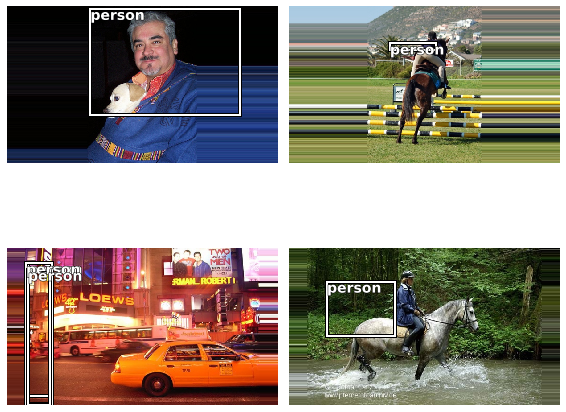

In [18]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(8,8))


In [14]:
device = 'cpu'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, arc=arc).to(device)

Using CPU



In [15]:
def loss_func(predicted, boxes, classes):
    targets = []
    bs = classes.shape[0]
    max_detections = classes.shape[1]
    for img_idx in range(bs):
        for detect_idx in range(max_detections):
            clazz = classes[img_idx, detect_idx]
            if clazz == 0: continue
            x, y, w, h = boxes[img_idx, detect_idx]
            targets.append([img_idx, float(clazz), float(x), float(y), float(w), float(h)])
    targets = tensor(targets)
    targets = build_targets(model, targets)
    loss = compute_loss(predicted, targets, model)
    return loss

In [16]:
learner = Learner(data, model, loss_func=loss_func)

In [17]:
model.arc = 'default'
model.nc = 7  # num classes
model.hyp = hyp
learner.fit(1)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/dist-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/usr/local/lib/python3.7/dist-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/usr/local/lib/python3.7/dist-packages/fastai/vision/data.py", line 355, in get
    return ImageBBox.create(*_get_size(self.x,i), *self.items[i], classes=self.classes, pad_idx=self.pad_idx)
  File "/usr/local/lib/python3.7/dist-packages/fastai/vision/image.py", line 359, in create
    tr_corners = torch.cat([bboxes[:,0][:,None], bboxes[:,3][:,None]], 1)
IndexError: too many indices for tensor of dimension 0


In [ ]:

       2 + 2